In [74]:
from pymongo import MongoClient
import pprint
import pandas as pd
# Requests sends and recieves HTTP requests.
import requests
import json
import time
from scipy import stats

In [3]:
import matplotlib.pyplot as plt

In [4]:
client = MongoClient('localhost', 27017)
results = client['results']
runners = results['indiv']
new = client['new_db']
indiv = new['individual']

In [5]:
results.list_collection_names()

['indiv', 'source']

In [6]:
len(list(runners.find()))

19311

In [7]:
### Create dataframe from indiv results collection, converts time to seconds
df = pd.DataFrame(list(runners.find()))
df.head()
df['Time(sec)'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)#.map('{:,.2f}'.format)
df.head()

,_id,name,time,age,ag,dist,Time(sec)
0,5f170b3bc94e506c54092382,Abdi Abdirahman,2:11:34,42,Men 40-44,Mar,7894
1,5f170b3bc94e506c54092383,Mustafa Mohamed,2:19:41,40,Men 40-44,Mar,8381
2,5f170b3bc94e506c54092384,Fredison Costa,2:21:29,42,Men 40-44,Mar,8489
3,5f170b3bc94e506c54092385,Vladimir Shatrov,2:26:17,41,Men 40-44,Mar,8777
4,5f170b3bc94e506c54092386,Miguel Ferrer,2:27:15,41,Men 40-44,Mar,8835


In [20]:
##set up 4 diff DF
agroup = ['Men 40-44', 'Men 45-49', 'Women 25-29', 'Women 30-34']
dist = ['Mar', 'Mar', 'Mile', 'Mile']

#M_Mar = df[df['ag']=='Men 40-44'& df['dist']=='Mar']

M_Mar = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[:2])]
W_Mar = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[:2])]
M_Mile = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[2:])]
W_Mile = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[2:])]

In [143]:
def add_quantile(df):
    cutoff = df['Time(sec)'].quantile(.75)
    df['upper quartiles'] = df['Time(sec)']<cutoff
    return df

    
raw_list_df = [M_Mar, W_Mar, M_Mile, W_Mile]

quant_list = [add_quantile(x) for x in raw_list_df]

quant_list[0].tail()
quant_list[1].describe()






/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


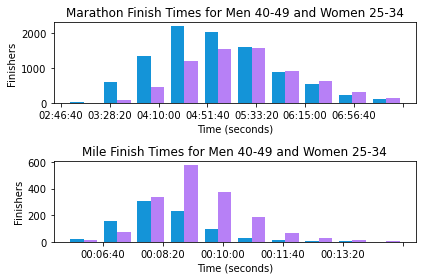

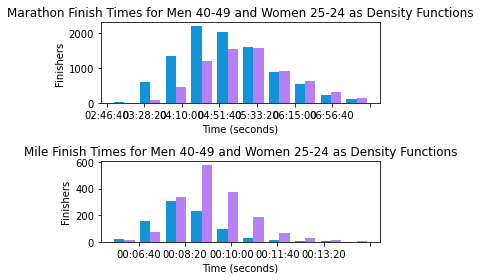

In [150]:
secs_mile = [300, 400, 500, 600, 700, 800]
secs_mar = [7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

def format_time(ls):
    l = []
    for i in ls:
        l.append(time.strftime('%H:%M:%S', time.gmtime(i)))
    return l


def plot_histograms(data, density = False):
    fig,ax = plt.subplots(2,1)

## marathon data
    ax[0].hist([data[0]['Time(sec)'], data[1]['Time(sec)']], bins = 10, range = (7800,25000), align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
    ax[0].spines["bottom"].set_visible(True)      
    ax[0].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
    if density == True:
        ax[0].set_title('Marathon Finish Times for Men 40-49 and Women 25-24 as Density Functions')
    else:
        ax[0].set_title('Marathon Finish Times for Men 40-49 and Women 25-34')
    ax[0].set_xlabel('Time (seconds)')
    ax[0].set_ylabel('Finishers')
    #ax[0].set_xticks(format_time(secs))
    ax[0].set_xticklabels(format_time(secs_mar))
##
    ax[1].hist([data[2]['Time(sec)'], data[3]['Time(sec)']], bins = 10, range = (240,800), align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
    ax[1].spines["bottom"].set_visible(True)      
    ax[1].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
    if density == True:
        ax[1].set_title('Mile Finish Times for Men 40-49 and Women 25-24 as Density Functions')
    else:
        ax[1].set_title('Mile Finish Times for Men 40-49 and Women 25-34')
    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Finishers')
    ax[1].set_xticklabels(format_time(secs_mile))

    fig.tight_layout()

plot_histograms(quant_list)
plot_histograms(quant_list, True)


In [129]:
men_mean = round(quant_list[0]['Time(sec)'].mean())
men_std = round(quant_list[0]['Time(sec)'].std())

print(men_mean)
women_mean = round(quant_list[1]['Time(sec)'].mean())
women_std = round(quant_list[1]['Time(sec)'].std())


def calculate_t_test(sample1, sample2, type_I_error_rate):
    ttest = stats.ttest_ind(sample1, sample2, equal_var = False)
    return (ttest[1], ttest[1] < type_I_error_rate)

error = .05
print(calculate_t_test((quant_list[0])['Time(sec)'], (quant_list[1])['Time(sec)'], error))
# print(results)
print('''The mean of the men's times is {} with a standard deviation of {}. 
For the women, the mean is {} with a standard deviation of {}. 
Using a t-test with {} significance, we get a p-value of {} meaning that the null hypothesis is {}.'''.format(men_mean, men_std, women_mean, women_std, 1- error, results[0], results == False)) 

15653
(6.172639721380716e-150, True)
The mean of the men's times is 15653 with a standard deviation of 3235. 
For the women, the mean is 16992 with a standard deviation of 3253. 
Using a t-test with 0.95 significance, we get a p-value of 6.172639721380716e-150 meaning that the null hypothesis is False.


In [96]:
men_mean = quant_list[0]['Time(sec)'].mean()
men_std = quant_list[0]['Time(sec)'].std()
print(type(men_mean))
women_mean = quant_list[1]['Time(sec)'].mean()
women_std = quant_list[1]['Time(sec)'].std()

TypeError: 'str' object is not callable

In [110]:
mean = quant_list[0]['Time(sec)'].mean()
mean

15652.911452427585

In [117]:
del print